### Regularization using Ridge and Lasso Method
1. Ridge (L2) - Penalty is applied on square of coefficients
2. Lasso (L1) - Penalty is applied on absolute values of coefficients

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

### Step 1: Data Ingestion


In [4]:
import pandas as pd
df = pd.read_csv("Cars93.csv", na_values=["","NA"], keep_default_na=False)
df.head()

,id,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,...,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Weight,Origin,Make
0,1,Acura,Integra,Small,12.9,15.9,18.8,25,31,None,...,5,177,102,68,37,26.5,11.0,2705,non-USA,Acura Integra
1,2,Acura,Legend,Midsize,29.2,33.9,38.7,18,25,Driver & Passenger,...,5,195,115,71,38,30.0,15.0,3560,non-USA,Acura Legend
2,3,Audi,90,Compact,25.9,29.1,32.3,20,26,Driver only,...,5,180,102,67,37,28.0,14.0,3375,non-USA,Audi 90
3,4,Audi,100,Midsize,30.8,37.7,44.6,19,26,NaN,...,6,193,106,70,37,31.0,17.0,3405,non-USA,Audi 100
4,5,BMW,535i,Midsize,23.7,30.0,36.2,22,30,Driver only,...,4,186,109,69,39,27.0,13.0,3640,non-USA,BMW 535i


##### Target Feature is Weight of the car

### Step 2: Perform Basic data quality checks

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  93 non-null     int64  
 1   Manufacturer        93 non-null     object 
 2   Model               93 non-null     object 
 3   Type                93 non-null     object 
 4   Min.Price           93 non-null     float64
 5   Price               93 non-null     float64
 6   Max.Price           93 non-null     float64
 7   MPG.city            93 non-null     int64  
 8   MPG.highway         93 non-null     int64  
 9   AirBags             89 non-null     object 
 10  DriveTrain          93 non-null     object 
 11  Cylinders           93 non-null     object 
 12  EngineSize          93 non-null     float64
 13  Horsepower          93 non-null     int64  
 14  RPM                 93 non-null     int64  
 15  Rev.per.mile        93 non-null     int64  
 16  Man.trans.

In [6]:
m = df.isna().sum()
m

id                     0
Manufacturer           0
Model                  0
Type                   0
Min.Price              0
Price                  0
Max.Price              0
MPG.city               0
MPG.highway            0
AirBags                4
DriveTrain             0
Cylinders              0
EngineSize             0
Horsepower             0
RPM                    0
Rev.per.mile           0
Man.trans.avail        0
Fuel.tank.capacity     0
Passengers             0
Length                 0
Wheelbase              0
Width                  0
Turn.circle            0
Rear.seat.room         2
Luggage.room          11
Weight                 0
Origin                 0
Make                   0
dtype: int64

In [7]:
m[m>0]

AirBags            4
Rear.seat.room     2
Luggage.room      11
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(0)

### Step 3: Separate X and Y (Weight)
id is statistically insignificant

In [10]:
X = df.drop(columns=["id","Weight"])
Y = df["Weight"]

In [11]:
X.head()

,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,...,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin,Make
0,Acura,Integra,Small,12.9,15.9,18.8,25,31,None,Front,...,13.2,5,177,102,68,37,26.5,11.0,non-USA,Acura Integra
1,Acura,Legend,Midsize,29.2,33.9,38.7,18,25,Driver & Passenger,Front,...,18.0,5,195,115,71,38,30.0,15.0,non-USA,Acura Legend
2,Audi,90,Compact,25.9,29.1,32.3,20,26,Driver only,Front,...,16.9,5,180,102,67,37,28.0,14.0,non-USA,Audi 90
3,Audi,100,Midsize,30.8,37.7,44.6,19,26,NaN,Front,...,21.1,6,193,106,70,37,31.0,17.0,non-USA,Audi 100
4,BMW,535i,Midsize,23.7,30.0,36.2,22,30,Driver only,Rear,...,21.1,4,186,109,69,39,27.0,13.0,non-USA,BMW 535i


In [12]:
Y.head()

0    2705
1    3560
2    3375
3    3405
4    3640
Name: Weight, dtype: int64

### Step 4 - Apply preprocessing on X

In [13]:
cat = X.columns[X.dtypes == "object"]
con = X.columns[X.dtypes != "object"]

In [14]:
cat

Index(['Manufacturer', 'Model', 'Type', 'AirBags', 'DriveTrain', 'Cylinders',
       'Man.trans.avail', 'Origin', 'Make'],
      dtype='object')

In [15]:
con

Index(['Min.Price', 'Price', 'Max.Price', 'MPG.city', 'MPG.highway',
       'EngineSize', 'Horsepower', 'RPM', 'Rev.per.mile', 'Fuel.tank.capacity',
       'Passengers', 'Length', 'Wheelbase', 'Width', 'Turn.circle',
       'Rear.seat.room', 'Luggage.room'],
      dtype='object')

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [17]:
# Make numerical pipeline
num_pipe = make_pipeline(
   SimpleImputer(strategy="mean"),
   StandardScaler()
)

In [18]:
# Make Categorical Pipeline
cat_pipe = make_pipeline(
   SimpleImputer(strategy="constant", fill_value="Not_Avail"),
   OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

In [22]:
# Combine the transformed dataset into one dataset using pre as ColumnTransofrmer Object
pre = ColumnTransformer(
   [
      ("num", num_pipe, con),
      ("cat", cat_pipe, cat)
   ]
).set_output(transform="pandas")

In [23]:
# Pass X to the ColumnTransformer object pre using fit_transofrm method
X_pre = pre.fit_transform(X) # Ask this to sir
X_pre.head()

,num__Min.Price,num__Price,num__Max.Price,num__MPG.city,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,...,cat__Make_Toyota Camry,cat__Make_Toyota Celica,cat__Make_Toyota Previa,cat__Make_Toyota Tercel,cat__Make_Volkswagen Corrado,cat__Make_Volkswagen Eurovan,cat__Make_Volkswagen Fox,cat__Make_Volkswagen Passat,cat__Make_Volvo 240,cat__Make_Volvo 850
0,-0.485787,-0.375720,-0.282465,0.471312,0.360925,-0.841022,-0.073484,1.717489,1.129530,-1.062184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.388017,1.497844,1.531409,-0.781032,-0.770514,0.515869,1.078322,0.369586,0.005661,0.409445,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.008658,0.998227,0.948052,-0.423219,-0.581941,0.128186,0.540813,0.369586,-0.105713,0.072197,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.571949,1.893374,2.069191,-0.602126,-0.581941,0.128186,0.540813,0.369586,0.410659,1.359872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.755752,1.091905,1.303535,-0.065407,0.172352,0.806631,1.231897,0.706562,0.430909,1.359872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Step 5: Apply Train Test Split
Using random state as 10

In [24]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y, test_size=0.2, random_state=10)

In [25]:
xtrain.head()

,num__Min.Price,num__Price,num__Max.Price,num__MPG.city,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,...,cat__Make_Toyota Camry,cat__Make_Toyota Celica,cat__Make_Toyota Previa,cat__Make_Toyota Tercel,cat__Make_Volkswagen Corrado,cat__Make_Volkswagen Eurovan,cat__Make_Volkswagen Fox,cat__Make_Volkswagen Passat,cat__Make_Volvo 240,cat__Make_Volvo 850
42,-0.382326,-0.209181,-0.063707,0.292406,0.360925,-0.453339,-0.073484,0.538074,0.562533,0.102856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,-0.715702,-0.823294,-0.874937,1.008032,1.303790,-0.841022,-0.783765,0.369586,-0.227212,-0.663618,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,1.422504,1.039862,0.692834,-0.423219,-0.581941,0.612789,0.060893,-0.809828,-1.108083,-0.203734,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.318914,0.134306,-0.018132,-0.602126,-0.204794,1.097393,0.502419,-0.809828,-1.543455,0.409445,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,-0.267368,-0.406946,-0.501224,-0.244313,-0.393368,-0.162577,-0.841356,-0.809828,0.268910,-0.203734,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
ytrain.head()

42    3040
53    2440
21    3570
6     3470
26    3080
Name: Weight, dtype: int64

In [27]:
xtest.head()

,num__Min.Price,num__Price,num__Max.Price,num__MPG.city,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,...,cat__Make_Toyota Camry,cat__Make_Toyota Celica,cat__Make_Toyota Previa,cat__Make_Toyota Tercel,cat__Make_Volkswagen Corrado,cat__Make_Volkswagen Eurovan,cat__Make_Volkswagen Fox,cat__Make_Volkswagen Passat,cat__Make_Volvo 240,cat__Make_Volvo 850
34,-0.497283,-0.573485,-0.610603,0.292406,0.172352,-0.647181,-0.553404,0.369586,0.015786,-0.357028,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90,0.663786,0.394523,0.164167,-0.781032,-0.770514,0.128186,0.655993,0.875050,0.106911,0.562740,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.571949,1.893374,2.069191,-0.602126,-0.581941,0.128186,0.540813,0.369586,0.410659,1.359872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,-0.301856,0.040627,0.310006,-1.317751,-1.713379,0.322027,0.022499,-0.809828,-0.510711,1.329213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.146478,-0.115503,-0.318925,-0.423219,-0.204794,0.612789,0.176074,0.032611,-0.692960,0.409445,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
ytest.head()

34    2710
90    2810
3     3405
35    3735
19    3515
Name: Weight, dtype: int64

In [29]:
xtrain.shape

(74, 258)

In [30]:
xtest.shape

(19, 258)

### Step 6: Model Building
##### A. Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression

model1 = LinearRegression()
model1.fit(xtrain,ytrain)

LinearRegression()

In [32]:
model1.score(xtrain, ytrain)

1.0

In [33]:
model1.score(xtest, ytest)

0.8390411685360826

### B. Ridge

In [34]:
from sklearn.linear_model import Ridge

model2 = Ridge(alpha=1) # Selecting random value for alpha

model2.fit(xtrain, ytrain)

Ridge(alpha=1)

In [35]:
model2.score(xtrain, ytrain)

0.9981487076293061

In [36]:
model2.score(xtest, ytest)

0.8554063893718669

### Hyperparameter Tuning
##### Alpha is hyperparameter
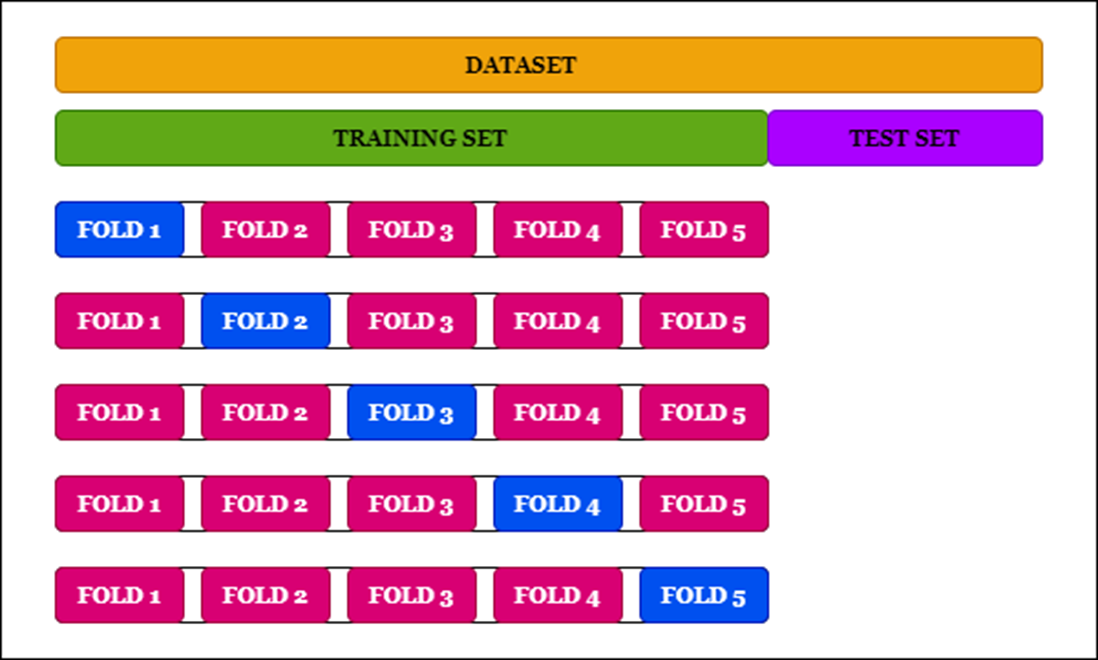

In [37]:
import numpy as np

params = {
   "alpha":np.arange(start=0.1, stop=100, step=0.1)
}

params

{'alpha': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
         1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
         2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
         3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
         4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
         5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
         6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
         7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
         8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
        10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11. ,
        11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. , 12.1,
        12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1, 13.2,
        13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2, 14.3,
        14.4, 14.5, 14.6, 14.

In [38]:
# To select the best Hyperparameter, use GridSearchCV (grid search cross validation for alpha value)
from sklearn.model_selection import GridSearchCV

base_ridge = Ridge()
gscv_ridge = GridSearchCV(base_ridge, param_grid=params, cv=5, scoring="r2", n_jobs=-1) # use n_jobs=-1 to utilize all available CPU cores
gscv_ridge.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,...
       92.5, 92.6, 92.7, 92.8, 92.9, 93. , 93.1, 93.2, 93.3, 93.4, 93.5,
       93.6, 93.7, 93.8, 93.9, 94. , 94.1, 94.2, 94.3, 94.4, 94.5, 94.6,
       94.7, 94.8, 94.9, 95. , 95.1, 95.2, 95.3, 95.4, 95.5, 95.6, 95.7,
       95.8, 95.9, 96. , 96.1, 96.2, 96.3, 96.4, 96.5, 96.6, 96.7, 96.8,
       96.9, 97. , 97.1, 97.2, 97.3, 97.4, 97.5, 97.6, 97.7, 97.8, 97.9,
       98. , 98.1, 98.2, 98.3, 98.4, 98.5, 98.6, 98.7, 98.8, 98.9, 99. ,
       99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9])},
             scoring='r2')

In [39]:
gscv_ridge.best_params_

{'alpha': np.float64(3.8000000000000003)}

In [40]:
gscv_ridge.best_score_

np.float64(0.9429856169884477)

In [41]:
best_ridge = gscv_ridge.best_estimator_

In [42]:
best_ridge

Ridge(alpha=np.float64(3.8000000000000003))

In [44]:
# Check the training score with best ridge model
best_ridge.score(xtrain, ytrain)

0.990614061944539

In [45]:
# Check the test score with the best ridge mode
best_ridge.score(xtest, ytest)

0.8807135645855573

### C. Lasso

In [46]:
from sklearn.linear_model import Lasso
model3 = Lasso(alpha=1)
model3.fit(xtrain, ytrain)

Lasso(alpha=1)

In [47]:
model3.score(xtrain, ytrain)

0.9937176439576964

In [48]:
model3.score(xtest, ytest)

0.8017469977835578

##### Since the model score for Lasso is near about 80% we will have to do the hyper parameter tuning for Lasso as well

### Hyperparameter tuning for Lasso Model

In [49]:
params2 = {
   "alpha":np.arange(start=0.1, stop=100, step=0.1)
}

In [50]:
params2

{'alpha': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
         1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
         2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
         3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
         4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
         5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
         6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
         7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
         8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
        10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11. ,
        11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. , 12.1,
        12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1, 13.2,
        13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2, 14.3,
        14.4, 14.5, 14.6, 14.

In [52]:
base_lasso = Lasso()
gscv_lasso = GridSearchCV(base_lasso, param_grid=params2, cv=5, scoring="r2", n_jobs=-1)
gscv_lasso.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,...
       92.5, 92.6, 92.7, 92.8, 92.9, 93. , 93.1, 93.2, 93.3, 93.4, 93.5,
       93.6, 93.7, 93.8, 93.9, 94. , 94.1, 94.2, 94.3, 94.4, 94.5, 94.6,
       94.7, 94.8, 94.9, 95. , 95.1, 95.2, 95.3, 95.4, 95.5, 95.6, 95.7,
       95.8, 95.9, 96. , 96.1, 96.2, 96.3, 96.4, 96.5, 96.6, 96.7, 96.8,
       96.9, 97. , 97.1, 97.2, 97.3, 97.4, 97.5, 97.6, 97.7, 97.8, 97.9,
       98. , 98.1, 98.2, 98.3, 98.4, 98.5, 98.6, 98.7, 98.8, 98.9, 99. ,
       99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9])},
             scoring='r2')

In [53]:
gscv_lasso.best_params_

{'alpha': np.float64(5.0)}

In [54]:
gscv_lasso.best_score_

np.float64(0.9403191008263132)

In [55]:
best_lasso = gscv_lasso.best_estimator_

In [56]:
best_lasso

Lasso(alpha=np.float64(5.0))

In [57]:
best_lasso.score(xtrain, ytrain) #Train the best lasso model with the training data

0.9715436760148632

In [58]:
best_lasso.score(xtest, ytest) # Send the test data to best lasso model

0.8679752238964454

### Step 7: Model Evaluation

In [59]:
from sklearn.metrics import (
   root_mean_squared_error,
   mean_absolute_error,
   mean_absolute_percentage_error,
   r2_score
)

In [60]:
def evaluate_model(model, x, y):
   ypred = model.predict(x)
   rmse = root_mean_squared_error(y, ypred)
   mae = mean_absolute_error(y, ypred)
   mape = mean_absolute_percentage_error(y, ypred)
   r2 = r2_score(y, ypred)

   print(f"RMSE: {rmse:.2f}")
   print(f'MAE: {mae:.2f}')
   print(f"MAPE: {mape:.2%}")
   print(f"R2: {r2:.2%}")

In [61]:
print("Linear Regresssion Test Reults:")
evaluate_model(model1, xtest, ytest)

Linear Regresssion Test Reults:
RMSE: 193.38
MAE: 147.26
MAPE: 4.91%
R2: 83.90%


In [62]:
print("Ridge Test Results:")
evaluate_model(best_ridge,xtest,ytest)

Ridge Test Results:
RMSE: 166.48
MAE: 129.71
MAPE: 4.37%
R2: 88.07%


In [63]:
print("Lasso Test Results:")
evaluate_model(best_lasso, xtest, ytest)

Lasso Test Results:
RMSE: 175.14
MAE: 131.91
MAPE: 4.47%
R2: 86.80%


#### From above results we can see Ridge Model has highest R2 score of 0.8807

### Step 8: Out of sample Prediction

In [64]:
xnew = pd.read_csv("sample.csv", na_values=["","NA"], keep_default_na=False)
xnew.head()

,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,...,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin,Make
0,Audi,100,Midsize,30.8,37.7,44.6,19,26,NaN,Front,...,15.0,6,190,106,65,37,31.0,17.0,non-USA,Audi 100
1,Pontiac,Sunbird,Compact,9.4,11.1,12.8,23,31,None,Front,...,15.2,5,181,101,66,39,25.0,13.0,USA,Pontiac Sunbird
2,Chevrolet,Lumina,Midsize,13.4,15.9,18.4,21,29,None,Front,...,16.5,6,198,108,71,40,28.5,16.0,USA,Chevrolet Lumina
3,Mazda,RX-7,Sporty,32.5,32.5,32.5,17,25,Driver only,Rear,...,20.0,2,169,96,69,37,NaN,NaN,non-USA,Mazda RX-7
4,Volkswagen,Fox,Small,8.7,9.1,9.5,25,33,None,Front,...,12.4,4,163,93,63,34,26.0,10.0,non-USA,Volkswagen Fox


In [65]:
pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Min.Price', 'Price', 'Max.Price', 'MPG.city', 'MPG.highway',
       'EngineSize', 'Horsepower', 'RPM', 'Rev.per.mile', 'Fuel.tank.capacity',
       'Passengers', 'Length', 'Wheelbase', 'Width', 'Turn.circle',
       'Rear.seat.room', 'Luggage.room'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Not_Avail',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Manufacturer', 'Model', 'Type', 'AirBags', 'DriveTrain', 'Cylinders',
       'Man.trans.avail', 'Origin', 'Make'],
      dtype='object'))])

In [66]:
xnew_pre = pre.transform(xnew)
xnew_pre

,num__Min.Price,num__Price,num__Max.Price,num__MPG.city,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,...,cat__Make_Toyota Camry,cat__Make_Toyota Celica,cat__Make_Toyota Previa,cat__Make_Toyota Tercel,cat__Make_Volkswagen Corrado,cat__Make_Volkswagen Eurovan,cat__Make_Volkswagen Fox,cat__Make_Volkswagen Passat,cat__Make_Volvo 240,cat__Make_Volvo 850
0,1.571949,1.893374,2.069191,-0.602126,-0.581941,0.128186,0.540813,0.369586,0.410659,-0.510323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.888138,-0.875337,-0.829362,0.113500,0.360925,-0.647181,-0.649388,-0.135877,0.673908,-0.449005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.428309,-0.375720,-0.318925,-0.244313,-0.016221,-0.453339,-0.649388,-0.135877,0.532158,-0.050439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.767376,1.352122,0.966282,-0.959938,-0.770514,-1.325626,2.134145,2.054464,-0.014589,1.022624,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.968608,-1.083511,-1.130155,0.471312,0.738071,-0.841022,-1.206095,0.369586,0.441034,-1.307455,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [67]:
preds = best_ridge.predict(xnew_pre)
preds

array([3351.86833353, 2653.53871607, 3058.65619781, 3266.67139689,
       2242.91780879])

In [68]:
xnew["Weight_Pred"] = preds

In [69]:
xnew = xnew.round(2)
xnew

,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,...,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin,Make,Weight_Pred
0,Audi,100,Midsize,30.8,37.7,44.6,19,26,NaN,Front,...,6,190,106,65,37,31.0,17.0,non-USA,Audi 100,3351.87
1,Pontiac,Sunbird,Compact,9.4,11.1,12.8,23,31,None,Front,...,5,181,101,66,39,25.0,13.0,USA,Pontiac Sunbird,2653.54
2,Chevrolet,Lumina,Midsize,13.4,15.9,18.4,21,29,None,Front,...,6,198,108,71,40,28.5,16.0,USA,Chevrolet Lumina,3058.66
3,Mazda,RX-7,Sporty,32.5,32.5,32.5,17,25,Driver only,Rear,...,2,169,96,69,37,NaN,NaN,non-USA,Mazda RX-7,3266.67
4,Volkswagen,Fox,Small,8.7,9.1,9.5,25,33,None,Front,...,4,163,93,63,34,26.0,10.0,non-USA,Volkswagen Fox,2242.92


In [70]:
xnew.to_csv("RidgeResults.csv", index=False)